# Generating Data

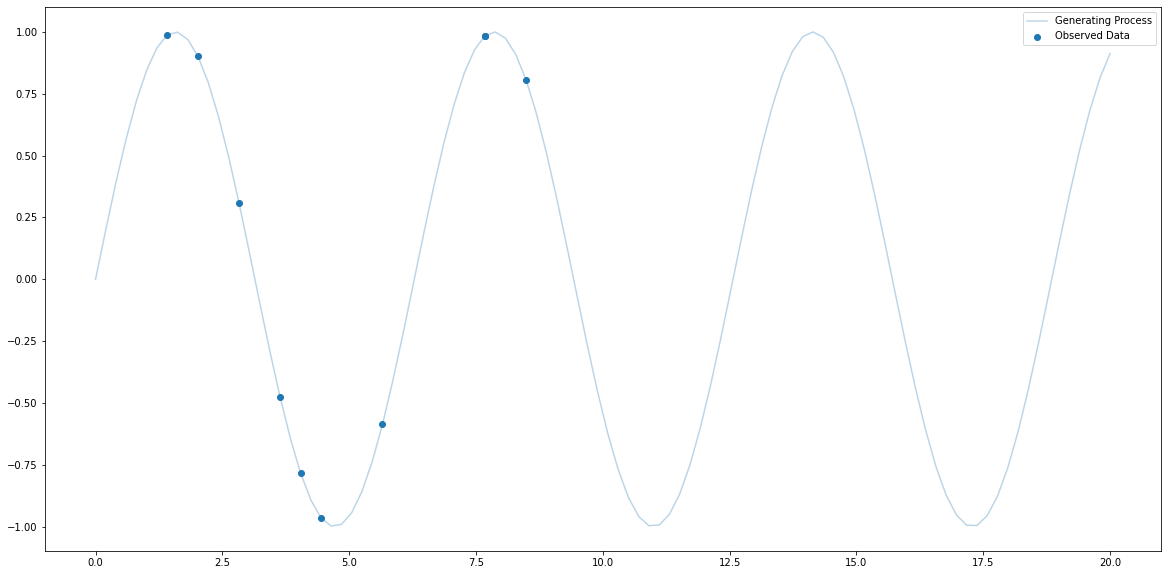

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

xs = np.linspace(0, 20, 100)
y = np.sin(xs)
noisy_y = y #+ np.random.normal(0, 0.1, size=100)

observation_indecies = np.random.choice(50, size=(10,))
observed_xs = xs[observation_indecies]
observed_y = noisy_y[observation_indecies]

_, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(xs, y, label="Generating Process", alpha=0.3)
ax.scatter(observed_xs, observed_y, label="Observed Data")
ax.legend()

# Vanilla Kernel Ridge Regression

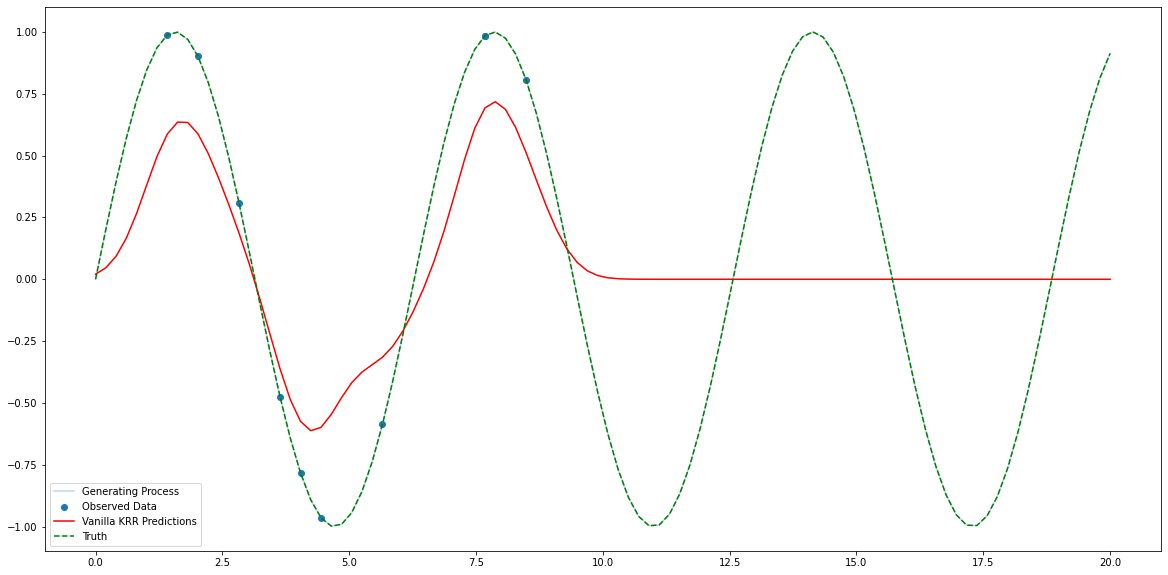

In [2]:
from sklearn.kernel_ridge import KernelRidge

kernel_ridge = KernelRidge(alpha=1, kernel='rbf', gamma=1.5)
kernel_ridge.fit(observed_xs.reshape(-1, 1), observed_y)

predicted_y = kernel_ridge.predict(xs.reshape(-1, 1))

_, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(xs, y, label="Generating Process", alpha=0.3)
ax.scatter(observed_xs, observed_y, label="Observed Data")
ax.plot(xs, predicted_y, label="Vanilla KRR Predictions", c='red')
ax.plot(xs, noisy_y, linestyle="--", c="green", label="Truth")
ax.legend()

In [3]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

interpolation_boundary = np.max(observation_indecies)
krr_interpolation_rmse = mean_squared_error(y_true=noisy_y[:interpolation_boundary + 1], y_pred=predicted_y[:interpolation_boundary + 1], squared=False)
krr_interpolation_mae = mean_absolute_error(y_true=noisy_y[:interpolation_boundary + 1], y_pred=predicted_y[:interpolation_boundary + 1])

krr_extrapolation_rmse = mean_squared_error(y_true=noisy_y[interpolation_boundary + 1:], y_pred=predicted_y[interpolation_boundary + 1:], squared=False)
krr_extrapolation_mae = mean_absolute_error(y_true=noisy_y[interpolation_boundary + 1:], y_pred=predicted_y[interpolation_boundary + 1:])

print(f"""\t\t| RMSE \t| MAE
===============================
Interpolation\t| {krr_interpolation_rmse:.3f} | {krr_interpolation_mae:.3f}
Extrapolation\t| {krr_extrapolation_rmse:.3f} | {krr_extrapolation_mae:.3f}""")

		| RMSE 	| MAE
Interpolation	| 0.312 | 0.280
Extrapolation	| 0.674 | 0.594


# CGC Framework

## Data Format Preparation

In [4]:
import pandas as pd

def setup_data():

    X = pd.DataFrame({
        "x": xs,
        "y": noisy_y
    })


    observed_ys = (y != y)
    observed_ys[observation_indecies] = True
    M = pd.DataFrame({
        "x": xs == xs,
        "y": observed_ys
    })

    X[~M] = 0

    X = np.asarray(X)
    M = np.asarray(M)

    return X, M

## Graph Completion with NGD

In [5]:
from cgc.graph import ComputationalGraph, derivative

graph = ComputationalGraph(observables_order=["x", "y"])

graph.add_observable("x")
graph.add_unknown_fn("x", "y", gamma=1.5, alpha=1)
graph.add_known_fn("y", "y'", fn=derivative)
graph.add_aggregator(["y", "y'"], "(y,y')")
graph.add_constraint("(y,y')", "W1", fn=lambda y_y_prime: y_y_prime[:, 0] ** 2 + y_y_prime[:, 1] ** 2 - 1)

X, M = setup_data()

Z = graph.complete(X, M)

Loss: 1940.1553:   4%|▎         | 17639/500000 [00:22<10:13, 785.99it/s] 

Stopped after 1000 steps with no improvment in Loss


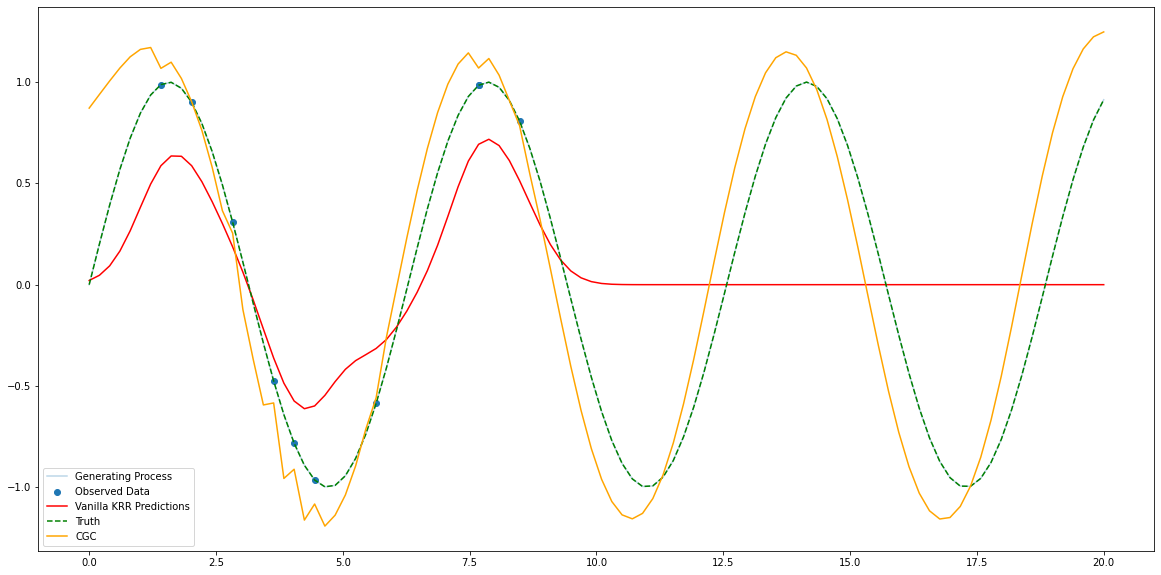

In [6]:
_, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(xs, y, label="Generating Process", alpha=0.3)
ax.scatter(observed_xs, observed_y, label="Observed Data")
ax.plot(xs, predicted_y, label="Vanilla KRR Predictions", c='red')
ax.plot(xs, noisy_y, linestyle="--", c="green", label="Truth")
ax.plot(xs, Z[:, 1], label="CGC", c='orange')
ax.legend()

In [7]:
interpolation_boundary = np.max(observation_indecies)
cgc_interpolation_rmse = mean_squared_error(y_true=noisy_y[:interpolation_boundary + 1], y_pred=Z[:interpolation_boundary + 1, 1], squared=False)
cgc_interpolation_mae = mean_absolute_error(y_true=noisy_y[:interpolation_boundary + 1], y_pred=Z[:interpolation_boundary + 1, 1])

cgc_extrapolation_rmse = mean_squared_error(y_true=noisy_y[interpolation_boundary + 1:], y_pred=Z[interpolation_boundary + 1:, 1], squared=False)
cgc_extrapolation_mae = mean_absolute_error(y_true=noisy_y[interpolation_boundary + 1:], y_pred=Z[interpolation_boundary + 1:, 1])

print(f"""\t\t| RMSE \t| MAE
===============================
Interpolation\t| {cgc_interpolation_rmse:.3f} | {cgc_interpolation_mae:.3f}
Extrapolation\t| {cgc_extrapolation_rmse:.3f} | {cgc_extrapolation_mae:.3f}""")

		| RMSE 	| MAE
Interpolation	| 0.281 | 0.209
Extrapolation	| 0.341 | 0.303
